In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Load all the processed datasets
file_paths = {
"medications": "ProcessedData/processed_medications.csv",
"observations": "ProcessedData/processed_observations.csv",
"patients": "ProcessedData/processed_patients.csv",
"allergies": "ProcessedData/processed_allergies.csv",
"careplans": "ProcessedData/processed_careplans.csv",
"conditions": "ProcessedData/processed_conditions.csv",
"immunizations": "ProcessedData/processed_immunizations.csv",
}

In [54]:

def load_and_merge_data(file_paths):
    # Read and standardize identifier columns to "id"
    data_frames = {}
    for key, path in file_paths.items():
        df = pd.read_csv(path)
        id_columns = [col for col in df.columns if "PATIENT" in col or "Id" in col or "id" in col]
        if id_columns:
            df.rename(columns={id_columns[0]: "id"}, inplace=True)
        # Add source-specific suffixes to columns (except "id")
        df.columns = [f"{col}_{key}" if col != "id" else "id" for col in df.columns]
        data_frames[key] = df

    # Print initial row counts
    for key, df in data_frames.items():
        print(f"Rows in {key}: {len(df)}")

    # Merge all dataframes on the 'id' column
    merged_data = data_frames["patients"]
    for key, df in data_frames.items():
        if key != "patients":
            merged_data = pd.merge(merged_data, df, on="id", how="left")

    # Print final row count
    print(f"Rows in final merged dataset: {len(merged_data)}")

    # Remove unnecessary columns used for label creation
    columns_to_remove = ['REASONDESCRIPTION_COVID-19_medications', 'COVID-19_conditions']
    columns_in_data = [col for col in columns_to_remove if col in merged_data.columns]
    if columns_in_data:
        merged_data.drop(columns=columns_in_data, inplace=True)
        print(f"Removed columns: {columns_in_data}")

    return merged_data

def preprocess_data(data):
    # Fill missing values
    data.fillna(0, inplace=True)

    # Normalize numerical columns
    numerical_cols = data.select_dtypes(include=[np.number]).columns
    scaler = StandardScaler()
    data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

    # Encode categorical columns
    categorical_cols = data.select_dtypes(include=['object', 'category']).columns
    for col in categorical_cols:
        # Convert all values to strings to handle mixed types
        data[col] = data[col].astype(str)
        encoder = LabelEncoder()
        data[col] = encoder.fit_transform(data[col])

    return data

def extract_high_correlation_features(data, target_column, threshold=0.9):
    # Calculate correlation matrix
    correlation_matrix = data.corr()
    # Extract features with correlation above the threshold
    high_corr_features = correlation_matrix[target_column][correlation_matrix[target_column] > threshold].index.tolist()
    return high_corr_features

def create_labels(data):
    labels = []
    for _, row in data.iterrows():
        if row["DECEASED_patients"] == 1:
            if "COVID-19_careplans" in row and row["COVID-19_careplans"] == 1:
                labels.append(0)  # Had COVID, died
            else:
                labels.append(1)  # Didn't have COVID, died
        else:
            if "COVID-19_careplans" in row and row["COVID-19_careplans"] == 1:
                labels.append(3)  # Had COVID, lived
            else:
                labels.append(2)  # Didn't have COVID, lived
    return np.array(labels)

def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.3),
        Conv1D(128, kernel_size=3, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def train_and_evaluate_model(merged_data):
    # Preprocess the data
    processed_data = preprocess_data(merged_data)
    labels = create_labels(processed_data)
    processed_data.drop(columns=["DECEASED_patients", "COVID-19_careplans"], inplace=True, errors='ignore')

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(processed_data, labels, test_size=0.2, random_state=42)
    y_train, y_test = to_categorical(y_train), to_categorical(y_test)

    # Build the CNN model
    input_shape = (X_train.shape[1], 1)
    model = build_cnn_model(input_shape, y_train.shape[1])

    # Train the model
    model.fit(X_train.values[..., np.newaxis], y_train, epochs=1, batch_size=32, validation_split=0.2)

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test.values[..., np.newaxis], y_test)
    print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

    # Predictions
    predictions = model.predict(X_test.values[..., np.newaxis])
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test, axis=1)

    # Classification report
    print("Classification Report:")
    print(classification_report(true_classes, predicted_classes))

    # Confusion matrix
    conf_matrix = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["COVID+Died", "NoCOVID+Died", "NoCOVID+Lived", "COVID+Lived"],
                yticklabels=["COVID+Died", "NoCOVID+Died", "NoCOVID+Lived", "COVID+Lived"])
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

    return model

In [55]:
# Load and merge the datasets
merged_data = load_and_merge_data(file_paths)

# Train and evaluate the model


c:\Users\sagor\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (3,13,57,70,84,132,162,181) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Rows in medications: 9566
Rows in observations: 12352
Rows in patients: 12352
Rows in allergies: 1528
Rows in careplans: 11771
Rows in conditions: 12165
Rows in immunizations: 10376
Rows in final merged dataset: 12352
Removed columns: ['REASONDESCRIPTION_COVID-19_medications', 'COVID-19_conditions']


78/78 [==============================] - 2s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Test Loss: 0.0, Test Accuracy: 1.0
78/78 [==============================] - 2s 23ms/step
Classification Report:
              precision    recall  f1-score   support

           2       1.00      1.00      1.00      2471

    accuracy                           1.00      2471
   macro avg       1.00      1.00      1.00      2471
weighted avg       1.00      1.00      1.00      2471



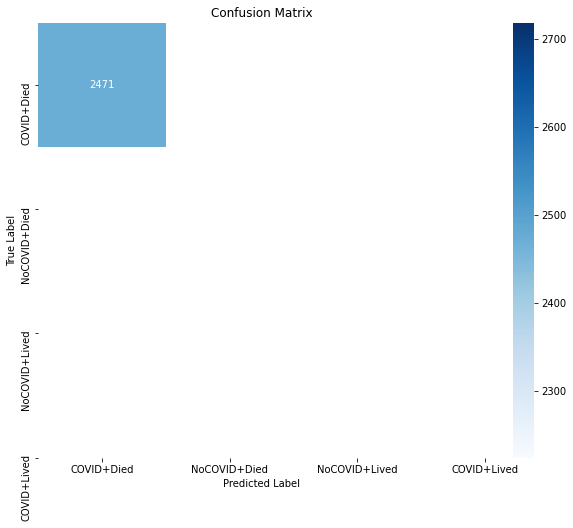

In [56]:
trained_model = train_and_evaluate_model(merged_data)

In [57]:
def extract_high_correlation_features(data, target_column, threshold=1.1):
    # Calculate correlation matrix
    correlation_matrix = data.corr()
    # Extract features with correlation above the threshold
    high_corr_features = correlation_matrix[target_column][correlation_matrix[target_column] >= threshold].index.tolist()
    return high_corr_features


# Extract high correlation features
high_corr_features = extract_high_correlation_features(merged_data, target_column='COVID-19_careplans', threshold=1.0)
print("Highly correlated features with COVID-19_careplans:", high_corr_features)


KeyError: 'COVID-19_careplans'